In [ ]:
import pandas as pd

data = pd.read_csv('/content/Spam_Detection.csv')
data.head()

,Label,Mail
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional

import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
def preprocess_text(text):

    text = BeautifulSoup(text, "html.parser").get_text()

    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    emoji_pattern = re.compile("["
                   u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002500-\U00002BEF"  # chinese char
                           u"\U00002702-\U000027B0"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001f926-\U0001f937"
                           u"\U00010000-\U0010ffff"
                           u"\u2640-\u2642"
                           u"\u2600-\u2B55"
                           u"\u200d"
                           u"\u23cf"
                           u"\u23e9"
                           u"\u231a"
                           u"\ufe0f"  # dingbats
                           u"\u3030"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)

    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'s", " is", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'t", " not", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'m", " am", text)
    text = text.lower()

    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    processed_text = ' '.join(lemmatized_tokens)
    return processed_text

In [ ]:
data['processed_text'] = data['Mail'].apply(preprocess_text)
data[['Mail', 'processed_text']].head()

<ipython-input-3-3ee9b1e39a29>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


,Mail,processed_text
0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...
3,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,"Nah I don't think he goes to usf, he lives aro...",nah dont think go usf life around though


In [ ]:
data=data.drop(['Mail'], axis=1)

In [ ]:
duplicate = data[data.duplicated()]
print(duplicate[:5])
len(duplicate)

    Label                                     processed_text
103   ham  per request melle melle oru minnaminunginte nu...
154   ham  per request melle melle oru minnaminunginte nu...
207   ham  entered cabin pa said happy bday bos felt spec...
223   ham                               sorry ill call later
326   ham                           callsmessagesmissed call


506

In [ ]:
data.groupby('Label').describe()

processed_text         \
               count unique   
Label                         
ham             4825   4483   
spam             747    583   

                                                               
                                                     top freq  
Label                                                          
ham                                 sorry ill call later   30  
spam   private account statement show unredeemed poin...    8

In [ ]:
spam_emails = data[data['Label'] == 'spam']
non_spam_emails = data[data['Label'] == 'ham']
spam_words = ' '.join(spam_emails['processed_text'].to_numpy().tolist())
non_spam_words = ' '.join(non_spam_emails['processed_text'].to_numpy().tolist())

In [ ]:
non_spam_emails_df=non_spam_emails.sample(n=len(spam_emails))
spam_emails_df=spam_emails
print(spam_emails_df.shape, non_spam_emails_df.shape)

(747, 2) (747, 2)


In [ ]:
emails=pd.concat([non_spam_emails_df,spam_emails_df]).reset_index(drop=True)

In [ ]:
emails['text_length']=emails['processed_text'].apply(len)
emails['email_type']=emails['Label'].map({'ham':0, 'spam':1})
emails_label=emails['email_type'].values
emails.head()

,Label,processed_text,text_length,email_type
0,ham,sorry ill call later,20,0
1,ham,working eye philosophy text u later bit free chat,49,0
2,ham,people see msg think iam addicted msging wrong...,94,0
3,ham,popping ibuprofen help,22,0
4,ham,ask say please message,22,0


In [ ]:
X = emails['processed_text']
y = emails['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [ ]:
max_len = 50
trunc_type = 'post'
padding_type = 'post'
oov_tok = ''
vocab_size = 500

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size,
                      char_level = False,
                      oov_token = oov_tok)

tokenizer.fit_on_texts(emails['processed_text'])
word_index = tokenizer.word_index

In [ ]:
total_words = len(word_index)
total_words

3658

In [ ]:
training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences,
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)

testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences,
                               maxlen = max_len,
                               padding = padding_type,
                               truncating = trunc_type)

In [ ]:
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (1195, 50)
Shape of testing tensor:  (299, 50)


In [ ]:
len(training_sequences[0]), len(training_sequences[1])

(18, 7)

In [ ]:
len(training_padded[0]), len(training_padded[1])

(50, 50)

In [ ]:
print(training_padded[0])

[433   1   1 250  38 364  38   1   1 452   1   1 102  69 188   1   5 452
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [ ]:
vocab_size = 500
embedding_dim = 16
drop_value = 0.2
n_dense = 24

In [ ]:
model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model1.add(SpatialDropout1D(0.2))
model1.add(LSTM(128, return_sequences=False))
model1.add(Dropout(0.2))
model1.add(Dense(1, activation='sigmoid'))
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 16)            8000      
                                                                 
 spatial_dropout1d_3 (Spati  (None, 50, 16)            0         
 alDropout1D)                                                    
                                                                 
 lstm_3 (LSTM)               (None, 128)               74240     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 82369 (321.75 KB)
Trainable params: 82369 (321.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(emails['Label'])
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)
y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

ValueError: y contains previously unseen labels: 0.0

In [ ]:
model1.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])
history = model1.fit(training_padded,y_train, epochs=20, batch_size=64,validation_data=(testing_padded, y_test),verbose=2)

Epoch 1/20
19/19 - 5s - loss: 0.1724 - accuracy: 0.9531 - val_loss: 0.2074 - val_accuracy: 0.9331 - 5s/epoch - 276ms/step
Epoch 2/20
19/19 - 3s - loss: 0.2169 - accuracy: 0.9272 - val_loss: 0.2089 - val_accuracy: 0.9365 - 3s/epoch - 141ms/step
Epoch 3/20
19/19 - 3s - loss: 0.1280 - accuracy: 0.9649 - val_loss: 0.2084 - val_accuracy: 0.9398 - 3s/epoch - 138ms/step
Epoch 4/20
19/19 - 2s - loss: 0.1327 - accuracy: 0.9640 - val_loss: 0.1896 - val_accuracy: 0.9431 - 2s/epoch - 100ms/step
Epoch 5/20
19/19 - 2s - loss: 0.1328 - accuracy: 0.9623 - val_loss: 0.1879 - val_accuracy: 0.9431 - 2s/epoch - 102ms/step
Epoch 6/20
19/19 - 2s - loss: 0.1173 - accuracy: 0.9699 - val_loss: 0.2130 - val_accuracy: 0.9398 - 2s/epoch - 97ms/step
Epoch 7/20
19/19 - 2s - loss: 0.1047 - accuracy: 0.9741 - val_loss: 0.1745 - val_accuracy: 0.9532 - 2s/epoch - 106ms/step
Epoch 8/20
19/19 - 2s - loss: 0.0949 - accuracy: 0.9782 - val_loss: 0.1828 - val_accuracy: 0.9498 - 2s/epoch - 126ms/step
Epoch 9/20
19/19 - 3s - l

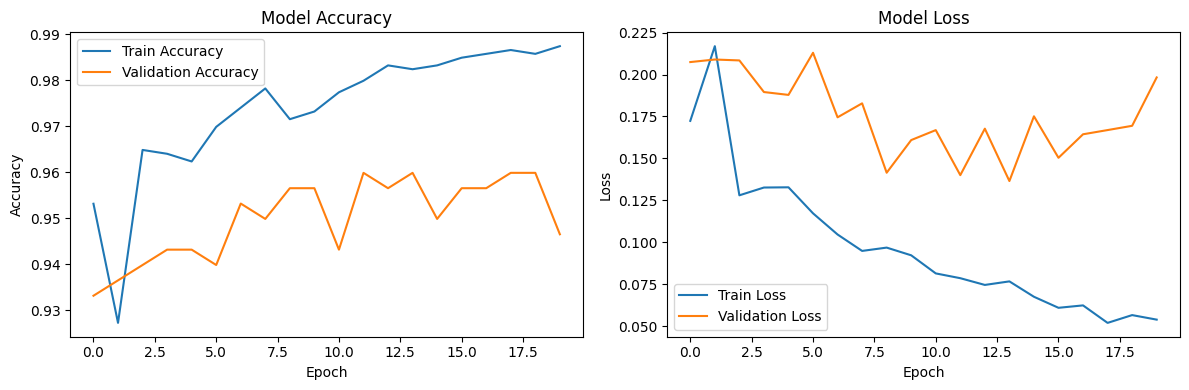

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
score = model1.evaluate(testing_padded, y_test, verbose=0)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.19826406240463257
Test Accuracy: 0.9464883208274841


In [ ]:
from sklearn.metrics import classification_report
y_pred=model1.predict(testing_padded)
y_pred=(y_pred>0.5).astype('int32')
print(classification_report(y_test, y_pred, target_names=['ham','spam']))

10/10 [==============================] - 0s 25ms/step
              precision    recall  f1-score   support

         ham       0.95      0.95      0.95       147
        spam       0.95      0.95      0.95       152

    accuracy                           0.95       299
   macro avg       0.95      0.95      0.95       299
weighted avg       0.95      0.95      0.95       299



In [ ]:
### RNN
from tensorflow.keras.layers import SimpleRNN
model2 = Sequential()
model2.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model2.add(SpatialDropout1D(0.2))
model2.add(SimpleRNN(128, return_sequences=False))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation='sigmoid'))
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 16)            8000      
                                                                 
 spatial_dropout1d_4 (Spati  (None, 50, 16)            0         
 alDropout1D)                                                    
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               18560     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 26689 (104.25 KB)
Trainable params: 26689 (104.25 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
model2.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])
history = model2.fit(training_padded,y_train, epochs=20, batch_size=64,validation_data=(testing_padded, y_test),verbose=2)

Epoch 1/20
19/19 - 2s - loss: 0.5169 - accuracy: 0.7615 - val_loss: 0.3837 - val_accuracy: 0.8294 - 2s/epoch - 125ms/step
Epoch 2/20
19/19 - 0s - loss: 0.3771 - accuracy: 0.8561 - val_loss: 0.2877 - val_accuracy: 0.8997 - 494ms/epoch - 26ms/step
Epoch 3/20
19/19 - 1s - loss: 0.2877 - accuracy: 0.8929 - val_loss: 0.2114 - val_accuracy: 0.9231 - 511ms/epoch - 27ms/step
Epoch 4/20
19/19 - 1s - loss: 0.3063 - accuracy: 0.8912 - val_loss: 0.3664 - val_accuracy: 0.8896 - 513ms/epoch - 27ms/step
Epoch 5/20
19/19 - 1s - loss: 0.2621 - accuracy: 0.9205 - val_loss: 0.2346 - val_accuracy: 0.9298 - 535ms/epoch - 28ms/step
Epoch 6/20
19/19 - 1s - loss: 0.1837 - accuracy: 0.9456 - val_loss: 0.2596 - val_accuracy: 0.9197 - 537ms/epoch - 28ms/step
Epoch 7/20
19/19 - 1s - loss: 0.1582 - accuracy: 0.9556 - val_loss: 0.2103 - val_accuracy: 0.9365 - 549ms/epoch - 29ms/step
Epoch 8/20
19/19 - 1s - loss: 0.1565 - accuracy: 0.9582 - val_loss: 0.2021 - val_accuracy: 0.9365 - 543ms/epoch - 29ms/step
Epoch 9/20

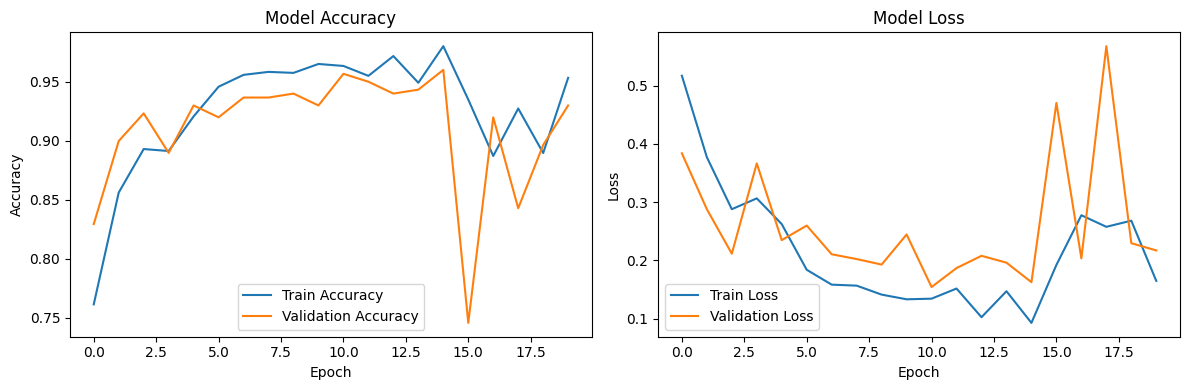

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
score = model2.evaluate(testing_padded, y_test, verbose=0)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.216889426112175
Test Accuracy: 0.9297658801078796


In [ ]:
y_pred=model2.predict(testing_padded)
y_pred=(y_pred>0.5).astype('int32')
print(classification_report(y_test, y_pred, target_names=['ham','spam']))

10/10 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

         ham       0.89      0.98      0.93       147
        spam       0.98      0.88      0.93       152

    accuracy                           0.93       299
   macro avg       0.93      0.93      0.93       299
weighted avg       0.93      0.93      0.93       299



In [ ]:
model3 = Sequential()
model3.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model3.add(SpatialDropout1D(0.2))
model3.add(GRU(128, return_sequences=False))
model3.add(Dropout(0.2))
model3.add(Dense(1, activation='sigmoid'))
model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 16)            8000      
                                                                 
 spatial_dropout1d_5 (Spati  (None, 50, 16)            0         
 alDropout1D)                                                    
                                                                 
 gru (GRU)                   (None, 128)               56064     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 64193 (250.75 KB)
Trainable params: 64193 (250.75 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
model3.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])
history = model3.fit(training_padded,y_train, epochs=20, batch_size=64,validation_data=(testing_padded, y_test),verbose=2)

Epoch 1/20
19/19 - 5s - loss: 0.6936 - accuracy: 0.4803 - val_loss: 0.6931 - val_accuracy: 0.5084 - 5s/epoch - 262ms/step
Epoch 2/20
19/19 - 3s - loss: 0.6941 - accuracy: 0.4937 - val_loss: 0.6933 - val_accuracy: 0.4916 - 3s/epoch - 148ms/step
Epoch 3/20
19/19 - 2s - loss: 0.6936 - accuracy: 0.4996 - val_loss: 0.6930 - val_accuracy: 0.5084 - 2s/epoch - 115ms/step
Epoch 4/20
19/19 - 2s - loss: 0.6936 - accuracy: 0.4870 - val_loss: 0.6936 - val_accuracy: 0.4916 - 2s/epoch - 80ms/step
Epoch 5/20
19/19 - 2s - loss: 0.6934 - accuracy: 0.4778 - val_loss: 0.6931 - val_accuracy: 0.5084 - 2s/epoch - 82ms/step
Epoch 6/20
19/19 - 2s - loss: 0.6939 - accuracy: 0.4870 - val_loss: 0.6937 - val_accuracy: 0.4916 - 2s/epoch - 80ms/step
Epoch 7/20
19/19 - 2s - loss: 0.6933 - accuracy: 0.5029 - val_loss: 0.6930 - val_accuracy: 0.5084 - 2s/epoch - 82ms/step
Epoch 8/20
19/19 - 2s - loss: 0.6934 - accuracy: 0.4845 - val_loss: 0.6932 - val_accuracy: 0.4916 - 2s/epoch - 79ms/step
Epoch 9/20
19/19 - 2s - loss:

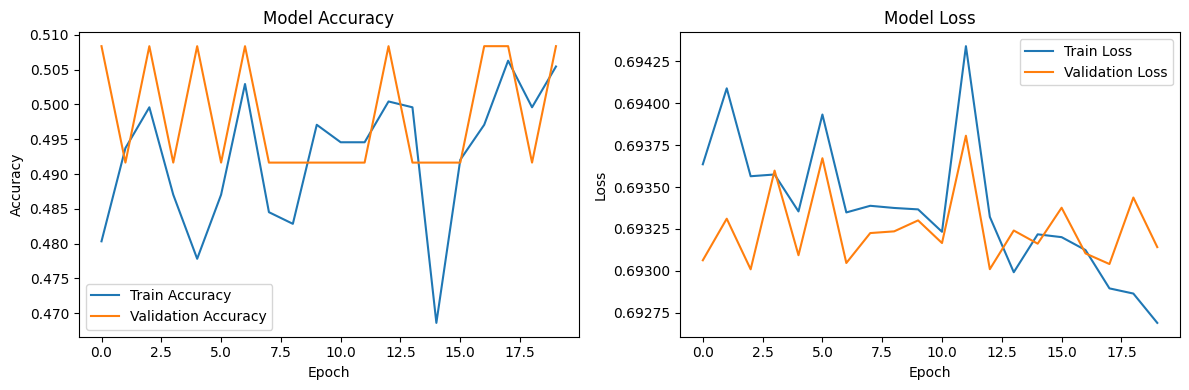

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
score = model3.evaluate(testing_padded, y_test, verbose=0)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.6931416988372803
Test Accuracy: 0.5083612203598022


In [ ]:
y_pred=model3.predict(testing_padded)
y_pred=(y_pred>0.5).astype('int32')
print(classification_report(y_test, y_pred, target_names=['ham','spam']))

10/10 [==============================] - 1s 14ms/step
              precision    recall  f1-score   support

         ham       0.00      0.00      0.00       147
        spam       0.51      1.00      0.67       152

    accuracy                           0.51       299
   macro avg       0.25      0.50      0.34       299
weighted avg       0.26      0.51      0.34       299



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import itertools

optimizers = [Adam, RMSprop, SGD]
learning_rates = [0.001, 0.01, 0.0001]
results = []

def build_compile_model(optimizer, learning_rate):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
    model.add(SpatialDropout1D(0.2))
    model.add(GRU(128, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    opt = optimizer(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
for optimizer, lr in itertools.product(optimizers, learning_rates):
  model = build_compile_model(optimizer, lr)
  print(f'Training with optimizer={optimizer.__name__}, learning_rate={lr}')
  history = model.fit(training_padded, y_train, epochs=10, batch_size=64, validation_data=(testing_padded, y_test), verbose=0)
  val_accuracy = history.history['val_accuracy'][-1]
  results.append((optimizer.__name__, lr, val_accuracy))

best_optimizer, best_lr, best_accuracy = max(results, key=lambda x: x[2])
print(f'Best optimizer: {best_optimizer}, Best learning rate: {best_lr}, Validation Accuracy: {best_accuracy}')

Training with optimizer=Adam, learning_rate=0.001
Training with optimizer=Adam, learning_rate=0.01
Training with optimizer=Adam, learning_rate=0.0001
Training with optimizer=RMSprop, learning_rate=0.001
Training with optimizer=RMSprop, learning_rate=0.01
Training with optimizer=RMSprop, learning_rate=0.0001
Training with optimizer=SGD, learning_rate=0.001
Training with optimizer=SGD, learning_rate=0.01
Training with optimizer=SGD, learning_rate=0.0001
Best optimizer: Adam, Best learning rate: 0.001, Validation Accuracy: 0.5083612203598022


In [ ]:
optimizers = [Adam, RMSprop, SGD]
learning_rates = [0.001, 0.01, 0.0001]
results = []

def build_compile_model(optimizer, learning_rate):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
    model.add(SpatialDropout1D(0.2))
    model.add(SimpleRNN(128, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    opt = optimizer(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
for optimizer, lr in itertools.product(optimizers, learning_rates):
  model = build_compile_model(optimizer, lr)
  print(f'Training with optimizer={optimizer.__name__}, learning_rate={lr}')
  history = model.fit(training_padded, y_train, epochs=10, batch_size=64, validation_data=(testing_padded, y_test), verbose=0)
  val_accuracy = history.history['val_accuracy'][-1]
  results.append((optimizer.__name__, lr, val_accuracy))

best_optimizer, best_lr, best_accuracy = max(results, key=lambda x: x[2])
print(f'Best optimizer: {best_optimizer}, Best learning rate: {best_lr}, Validation Accuracy: {best_accuracy}')

Training with optimizer=Adam, learning_rate=0.001
Training with optimizer=Adam, learning_rate=0.01
Training with optimizer=Adam, learning_rate=0.0001
Training with optimizer=RMSprop, learning_rate=0.001
Training with optimizer=RMSprop, learning_rate=0.01
Training with optimizer=RMSprop, learning_rate=0.0001
Training with optimizer=SGD, learning_rate=0.001
Training with optimizer=SGD, learning_rate=0.01
Training with optimizer=SGD, learning_rate=0.0001
Best optimizer: Adam, Best learning rate: 0.001, Validation Accuracy: 0.9364548325538635


In [ ]:
optimizers = [Adam, RMSprop, SGD]
learning_rates = [0.001, 0.01, 0.0001]
results = []

def build_compile_model(optimizer, learning_rate):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    opt = optimizer(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
for optimizer, lr in itertools.product(optimizers, learning_rates):
  model = build_compile_model(optimizer, lr)
  print(f'Training with optimizer={optimizer.__name__}, learning_rate={lr}')
  history = model.fit(training_padded, y_train, epochs=10, batch_size=64, validation_data=(testing_padded, y_test), verbose=0)
  val_accuracy = history.history['val_accuracy'][-1]
  results.append((optimizer.__name__, lr, val_accuracy))

best_optimizer, best_lr, best_accuracy = max(results, key=lambda x: x[2])
print(f'Best optimizer: {best_optimizer}, Best learning rate: {best_lr}, Validation Accuracy: {best_accuracy}')

Training with optimizer=Adam, learning_rate=0.001
Training with optimizer=Adam, learning_rate=0.01
Training with optimizer=Adam, learning_rate=0.0001
Training with optimizer=RMSprop, learning_rate=0.001
Training with optimizer=RMSprop, learning_rate=0.01
Training with optimizer=RMSprop, learning_rate=0.0001
Training with optimizer=SGD, learning_rate=0.001
Training with optimizer=SGD, learning_rate=0.01
Training with optimizer=SGD, learning_rate=0.0001
Best optimizer: Adam, Best learning rate: 0.001, Validation Accuracy: 0.9063544869422913


In [ ]:
spam_emails = data[data['Label'] == 'spam']
non_spam_emails = data[data['Label'] == 'ham']
from collections import Counter
from nltk.tokenize import word_tokenize

spam_words = ' '.join(spam_emails['processed_text'])
spam_word_tokens = word_tokenize(spam_words)
spam_word_freq = Counter(spam_word_tokens)

non_spam_words = ' '.join(non_spam_emails['processed_text'])
non_spam_word_tokens = word_tokenize(non_spam_words)
non_spam_word_freq = Counter(non_spam_word_tokens)

print("Top 10 words in spam emails:")
print(spam_word_freq.most_common(10))

print("\nTop 10 words in non-spam emails:")
print(non_spam_word_freq.most_common(10))

Top 10 words in spam emails:
[('call', 359), ('free', 219), ('u', 161), ('txt', 150), ('ur', 144), ('text', 138), ('mobile', 136), ('stop', 118), ('claim', 113), ('reply', 103)]

Top 10 words in non-spam emails:
[('u', 1056), ('im', 463), ('get', 318), ('go', 278), ('dont', 276), ('ok', 273), ('ur', 246), ('got', 245), ('come', 245), ('call', 243)]


In [ ]:
non_spam_emails_df=non_spam_emails.sample(n=len(spam_emails))
spam_emails_df=spam_emails
print(spam_emails_df.shape, non_spam_emails_df.shape)

(747, 2) (747, 2)


In [ ]:
print(data['Label'].value_counts())

from imblearn.over_sampling import SMOTE
from collections import Counter

X = data['processed_text']
y = data['Label']

Label
ham     4825
spam     747
Name: count, dtype: int64


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! unzip '/content/drive/MyDrive/Colab Notebooks/RNN2_Dataset/Train.zip' -d '/content/drive/MyDrive/Colab Notebooks/'

Archive:  /content/drive/MyDrive/Colab Notebooks/RNN2_Dataset/Train.zip
  inflating: /content/drive/MyDrive/Colab Notebooks/train/2694MN.wav  
  inflating: /content/drive/MyDrive/Colab Notebooks/train/2700MN.wav  
  inflating: /content/drive/MyDrive/Colab Notebooks/train/2671MN.wav  
  inflating: /content/drive/MyDrive/Colab Notebooks/train/2686MN.wav  
  inflating: /content/drive/MyDrive/Colab Notebooks/train/2677FW.wav  
  inflating: /content/drive/MyDrive/Colab Notebooks/train/1042FA.wav  
  inflating: /content/drive/MyDrive/Colab Notebooks/train/2679FA.wav  
  inflating: /content/drive/MyDrive/Colab Notebooks/train/2698MA.wav  
  inflating: /content/drive/MyDrive/Colab Notebooks/train/2681FW.wav  
  inflating: /content/drive/MyDrive/Colab Notebooks/train/2674FS.wav  
  inflating: /content/drive/MyDrive/Colab Notebooks/train/2682MN.wav  
  inflating: /content/drive/MyDrive/Colab Notebooks/train/2084MN.wav  
  inflating: /content/drive/MyDrive/Colab Notebooks/train/1112FS.wav  
  inf

In [ ]:
! unzip '/content/drive/MyDrive/Colab Notebooks/RNN2_Dataset/Test.zip' -d '/content/drive/MyDrive/Colab Notebooks/'

Archive:  /content/drive/MyDrive/Colab Notebooks/RNN2_Dataset/Test.zip
  inflating: /content/drive/MyDrive/Colab Notebooks/test/2986M.wav  
  inflating: /content/drive/MyDrive/Colab Notebooks/test/2995M.wav  
  inflating: /content/drive/MyDrive/Colab Notebooks/test/2996F.wav  
  inflating: /content/drive/MyDrive/Colab Notebooks/test/2987F.wav  
  inflating: /content/drive/MyDrive/Colab Notebooks/test/2982M.wav  
  inflating: /content/drive/MyDrive/Colab Notebooks/test/2964F.wav  
  inflating: /content/drive/MyDrive/Colab Notebooks/test/2965M.wav  
  inflating: /content/drive/MyDrive/Colab Notebooks/test/2988M.wav  
  inflating: /content/drive/MyDrive/Colab Notebooks/test/2973M.wav  
  inflating: /content/drive/MyDrive/Colab Notebooks/test/2983M.wav  
  inflating: /content/drive/MyDrive/Colab Notebooks/test/2967M.wav  
  inflating: /content/drive/MyDrive/Colab Notebooks/test/2963M.wav  
  inflating: /content/drive/MyDrive/Colab Notebooks/test/2976M.wav  
  inflating: /content/drive/MyDr

In [ ]:
def parser(name):
  meta = {}
  meta['id'] = name.split('.')[0][:-2]
  meta['gender'] = name.split('.')[0][-2]
  meta['label'] = name.split('.')[0][-1]
  return meta

In [ ]:
import os

file_names = os.listdir('/content/drive/MyDrive/Colab Notebooks/train')
test_file_names = os.listdir('/content/drive/MyDrive/Colab Notebooks/test')

In [ ]:
import librosa

audio_data = []
root = '/content/drive/MyDrive/Colab Notebooks/'

for file_name in file_names:
  y, sr = librosa.load(root + 'train/' + file_name)
  mfccs = librosa.feature.mfcc(y=y, sr=sr,n_mfcc=10)
  audio_data.append(mfccs)

In [ ]:
import librosa

audio_data_test = []
root = '/content/drive/MyDrive/Colab Notebooks/'

for test_file_name in file_names:
  y, sr = librosa.load(root + 'train/' + file_name)
  mfccs = librosa.feature.mfcc(y=y, sr=sr,n_mfcc=10)
  audio_data_test.append(mfccs)

In [ ]:
import numpy as np
fixed_audio_data = []
for i in audio_data:
  fixed_data = np.zeros((400, 10))
  fixed_data[0:i.T.shape[0], :] = i.T[0:400, :]

  fixed_audio_data.append(fixed_data)

In [ ]:
train_y = []

for i in file_names:
  train_y.append(parser(i)['label'])

In [ ]:
from keras.utils import to_categorical

classes = ['A', 'H', 'S', 'N', 'W']
mapping = {}
for x in range(5):
  mapping[classes[x]] = x

for x in range(len(train_y)):
  train_y[x] = mapping[train_y[x]]

train_y = to_categorical(train_y)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

sc = MinMaxScaler()
train_x = []
for i in fixed_audio_data:
  train_x.append(sc.fit_transform(i))

pd.DataFrame(fixed_audio_data[0])

,0,1,2,3,4,5,6,7,8,9
0,-545.837219,74.421753,40.863106,20.462782,15.470819,10.865889,3.028809,-0.336740,-2.227835,-9.206074
1,-377.993439,166.152740,63.075779,-14.615841,-16.987576,10.160603,-3.244180,2.921024,-9.575747,-23.915878
2,-269.446106,167.498627,58.980171,-23.021530,-38.838821,10.900232,-9.061716,12.430090,-6.808980,-29.192883
3,-220.079727,152.148376,49.101868,-21.890709,-52.994545,12.926222,-5.473449,26.559500,-8.766838,-33.370247
4,-200.915726,137.506531,40.598633,-20.538109,-59.925640,14.581399,-7.588870,44.495731,-10.515352,-37.183380
...,...,...,...,...,...,...,...,...,...,...
395,-252.725937,-7.190848,-84.560776,37.903622,20.142227,39.105343,-24.128214,10.236664,-1.932083,1.833157
396,-254.600693,4.233741,-93.446747,26.501686,3.647534,41.445984,-17.034290,-6.656097,-10.787064,-3.148252
397,-258.080902,33.427967,-84.077011,21.073730,8.863987,46.581352,-6.453749,-5.458885,-20.613728,-3.801999
398,-278.892761,81.278397,-49.567986,21.744991,17.829384,52.278763,4.859374,-0.856358,-17.713943,-5.092294


In [ ]:
pd.DataFrame(train_x[0])

,0,1,2,3,4,5,6,7,8,9
0,0.109178,0.491631,0.737060,0.480121,0.720513,0.467956,0.585016,0.339949,0.544844,0.380508
1,0.461256,0.807258,0.858957,0.244257,0.502241,0.460556,0.530070,0.380637,0.464951,0.237897
2,0.688950,0.811889,0.836482,0.187738,0.355299,0.468317,0.479113,0.499400,0.495034,0.186737
3,0.792504,0.759072,0.782272,0.195341,0.260106,0.489574,0.510543,0.675869,0.473746,0.146238
4,0.832703,0.708692,0.735608,0.204436,0.213497,0.506941,0.492014,0.899884,0.454735,0.109269
...,...,...,...,...,...,...,...,...,...,...
395,0.724024,0.210819,0.048764,0.597391,0.751927,0.764260,0.347141,0.472005,0.548060,0.487533
396,0.720091,0.250129,0.000000,0.520726,0.641005,0.788820,0.409279,0.261023,0.451780,0.439238
397,0.712791,0.350580,0.051419,0.484229,0.676084,0.842703,0.501956,0.275976,0.344936,0.432900
398,0.669135,0.515223,0.240796,0.488743,0.736374,0.902483,0.601051,0.333459,0.376465,0.420391


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_x, train_y, train_size=0.8, shuffle=True)

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn import metrics
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Dropout, Input, Activation

model = Sequential()
model.add(LSTM(128, return_sequences=False, input_shape=(None, 10)))
model.add(Dense(5, activation='softmax'))
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               71168     
                                                                 
 dense (Dense)               (None, 5)                 645       
                                                                 
Total params: 71813 (280.52 KB)
Trainable params: 71813 (280.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
history=model.fit(x_train, y_train, batch_size=32, epochs=50,validation_data=(x_test, y_test))

Epoch 1/50
50/50 [==============================] - 30s 550ms/step - loss: 0.1416 - accuracy: 0.3894 - val_loss: 0.1228 - val_accuracy: 0.5564
Epoch 2/50
50/50 [==============================] - 28s 566ms/step - loss: 0.1274 - accuracy: 0.5295 - val_loss: 0.1185 - val_accuracy: 0.5664
Epoch 3/50
50/50 [==============================] - 27s 548ms/step - loss: 0.1243 - accuracy: 0.5421 - val_loss: 0.1297 - val_accuracy: 0.5138
Epoch 4/50
50/50 [==============================] - 27s 552ms/step - loss: 0.1221 - accuracy: 0.5440 - val_loss: 0.1174 - val_accuracy: 0.5664
Epoch 5/50
50/50 [==============================] - 27s 537ms/step - loss: 0.1197 - accuracy: 0.5634 - val_loss: 0.1116 - val_accuracy: 0.6216
Epoch 6/50
50/50 [==============================] - 26s 519ms/step - loss: 0.1184 - accuracy: 0.5735 - val_loss: 0.1125 - val_accuracy: 0.6040
Epoch 7/50
50/50 [==============================] - 28s 559ms/step - loss: 0.1179 - accuracy: 0.5741 - val_loss: 0.1254 - val_accuracy: 0.5288

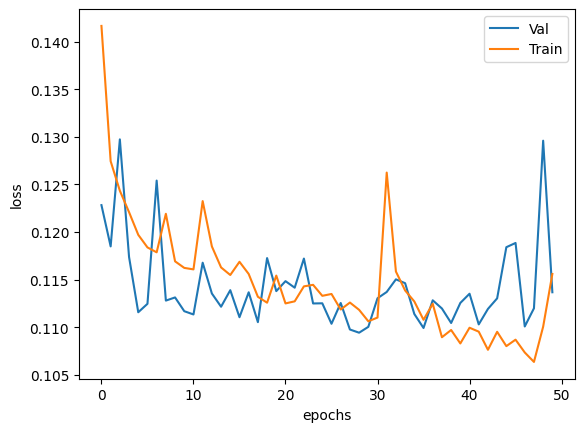

In [ ]:
from matplotlib import pyplot as plt

val_accuracy = history.history['val_loss']
valacc = history.history['loss']
plt.plot(val_accuracy)
plt.plot(valacc)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Val','Train'])
plt.show()

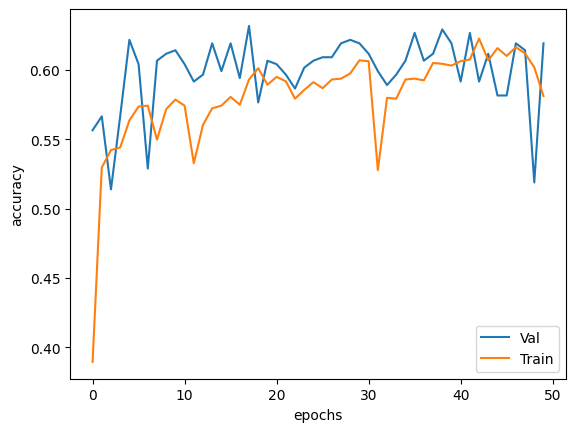

In [ ]:
val_accuracy = history.history['val_accuracy']
valacc = history.history['accuracy']
plt.plot(val_accuracy)
plt.plot(valacc)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Val','Train'])
plt.show()


In [ ]:
##LSTM
model = Sequential()
model.add(LSTM(128, return_sequences=False, input_shape=(None, 10), dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               71168     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 32)                4128      
                                                                 
 dense_4 (Dense)             (None, 5)                 165       
                                                                 
Total params: 92037 (359.52 KB)
Trainable params: 9203

In [ ]:
history=model.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
50/50 [==============================] - 31s 570ms/step - loss: 0.1454 - accuracy: 0.3712 - val_loss: 0.1359 - val_accuracy: 0.4236
Epoch 2/100
50/50 [==============================] - 27s 545ms/step - loss: 0.1419 - accuracy: 0.4359 - val_loss: 0.1778 - val_accuracy: 0.4060
Epoch 3/100
50/50 [==============================] - 28s 572ms/step - loss: 0.1467 - accuracy: 0.3857 - val_loss: 0.1366 - val_accuracy: 0.4085
Epoch 4/100
50/50 [==============================] - 28s 567ms/step - loss: 0.1325 - accuracy: 0.5057 - val_loss: 0.1168 - val_accuracy: 0.5840
Epoch 5/100
50/50 [==============================] - 26s 521ms/step - loss: 0.1405 - accuracy: 0.4711 - val_loss: 0.1315 - val_accuracy: 0.5238
Epoch 6/100
50/50 [==============================] - 26s 521ms/step - loss: 0.1283 - accuracy: 0.5245 - val_loss: 0.1162 - val_accuracy: 0.5840
Epoch 7/100
50/50 [==============================] - 27s 544ms/step - loss: 0.1250 - accuracy: 0.5440 - val_loss: 0.1210 - val_accuracy:

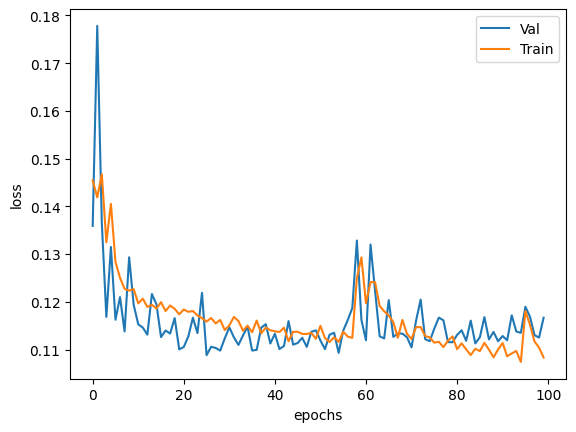

In [ ]:
val_accuracy = history.history['val_loss']
valacc = history.history['loss']
plt.plot(val_accuracy)
plt.plot(valacc)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Val','Train'])
plt.show()

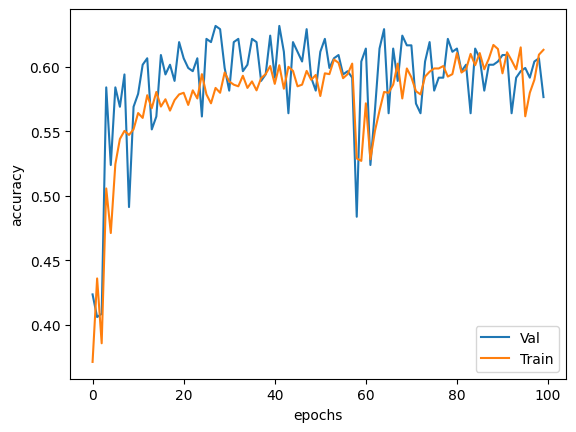

In [ ]:
val_accuracy = history.history['val_accuracy']
valacc = history.history['accuracy']
plt.plot(val_accuracy)
plt.plot(valacc)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Val','Train'])
plt.show()

In [ ]:
lstm_loss, lstm_accuracy= model.evaluate(x_test,y_test)

13/13 [==============================] - 2s 158ms/step - loss: 0.1167 - accuracy: 0.5764


In [ ]:
import numpy as np
fixed_audio_data_test = []
for i in audio_data_test:
  fixed_data_test = np.zeros((400, 10))
  fixed_data_test[0:i.T.shape[0], :] = i.T[0:400, :]

  fixed_audio_data_test.append(fixed_data_test)

In [ ]:
test_y = []

for i in file_names:
  test_y.append(parser(i)['label'])

In [ ]:
from keras.utils import to_categorical

classes = ['A', 'H', 'S', 'N', 'W']
mapping = {}
for x in range(5):
  mapping[classes[x]] = x

for x in range(len(test_y)):
  test_y[x] = mapping[test_y[x]]

test_y = to_categorical(test_y)

In [ ]:
sc = MinMaxScaler()
test_x = []
for i in fixed_audio_data_test:
  test_x.append(sc.fit_transform(i))

pd.DataFrame(fixed_audio_data_test[0])

In [ ]:
pd.DataFrame(test_x[0])

In [ ]:
train_x_male = []
train_x_female = []
train_y_male = []
train_y_female = []

for i in range(len(file_names)):
  meta = parser(file_names[i])
  if meta['gender'] == 'M':
    train_x_male.append(train_x[i])
    train_y_male.append(train_y[i])
  if meta['gender'] == 'F':
    train_x_female.append(train_x[i])
    train_y_female.append(train_y[i])

In [ ]:
x_train_male, x_test_male, y_train_male, y_test_male = train_test_split(train_x_male, train_y_male, train_size=0.8, shuffle=True)
x_train_female, x_test_female, y_train_female, y_test_female = train_test_split(train_x_female, train_y_female, train_size=0.8, shuffle=True)

In [ ]:
x_train_male = np.array(x_train_male)
y_train_male = np.array(y_train_male)
x_test_male = np.array(x_test_male)
y_test_male = np.array(y_test_male)
history=model.fit(x_train_male, y_train_male, batch_size=32, epochs=50,validation_data=(x_test_male, y_test_male))

Epoch 1/50
29/29 [==============================] - 16s 570ms/step - loss: 0.1022 - accuracy: 0.6284 - val_loss: 0.1004 - val_accuracy: 0.6450
Epoch 2/50
29/29 [==============================] - 16s 542ms/step - loss: 0.0977 - accuracy: 0.6576 - val_loss: 0.1100 - val_accuracy: 0.6364
Epoch 3/50
29/29 [==============================] - 16s 548ms/step - loss: 0.0999 - accuracy: 0.6544 - val_loss: 0.1001 - val_accuracy: 0.6494
Epoch 4/50
29/29 [==============================] - 16s 539ms/step - loss: 0.0977 - accuracy: 0.6598 - val_loss: 0.1012 - val_accuracy: 0.6320
Epoch 5/50
29/29 [==============================] - 16s 549ms/step - loss: 0.0959 - accuracy: 0.6598 - val_loss: 0.1025 - val_accuracy: 0.6277
Epoch 6/50
29/29 [==============================] - 15s 536ms/step - loss: 0.0987 - accuracy: 0.6490 - val_loss: 0.1091 - val_accuracy: 0.6407
Epoch 7/50
29/29 [==============================] - 16s 547ms/step - loss: 0.0957 - accuracy: 0.6587 - val_loss: 0.1019 - val_accuracy: 0.6364

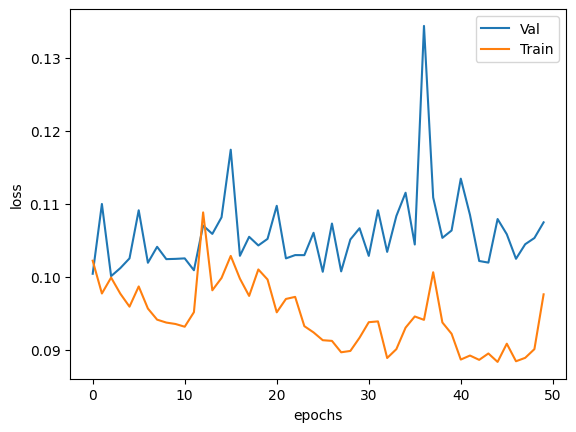

In [ ]:
val_accuracy = history.history['val_loss']
valacc = history.history['loss']
plt.plot(val_accuracy)
plt.plot(valacc)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Val','Train'])
plt.show()

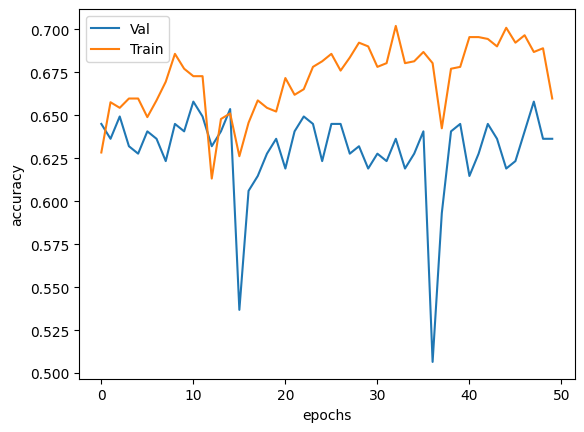

In [ ]:
val_accuracy = history.history['val_accuracy']
valacc = history.history['accuracy']
plt.plot(val_accuracy)
plt.plot(valacc)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Val','Train'])
plt.show()

In [ ]:
x_train_female = np.array(x_train_female)
y_train_female = np.array(y_train_female)
x_test_female = np.array(x_test_female)
y_test_female = np.array(y_test_female)
history=model.fit(x_train_female, y_train_female, batch_size=32, epochs=50,validation_data=(x_test_female, y_test_female))

Epoch 1/50
21/21 [==============================] - 11s 522ms/step - loss: 0.1393 - accuracy: 0.4634 - val_loss: 0.1262 - val_accuracy: 0.5298
Epoch 2/50
21/21 [==============================] - 12s 569ms/step - loss: 0.1281 - accuracy: 0.5396 - val_loss: 0.1201 - val_accuracy: 0.5476
Epoch 3/50
21/21 [==============================] - 12s 581ms/step - loss: 0.1288 - accuracy: 0.5127 - val_loss: 0.1204 - val_accuracy: 0.5357
Epoch 4/50
21/21 [==============================] - 10s 474ms/step - loss: 0.1276 - accuracy: 0.5202 - val_loss: 0.1208 - val_accuracy: 0.5298
Epoch 5/50
21/21 [==============================] - 11s 533ms/step - loss: 0.1256 - accuracy: 0.5381 - val_loss: 0.1178 - val_accuracy: 0.5595
Epoch 6/50
21/21 [==============================] - 12s 598ms/step - loss: 0.1251 - accuracy: 0.5336 - val_loss: 0.1171 - val_accuracy: 0.5833
Epoch 7/50
21/21 [==============================] - 12s 595ms/step - loss: 0.1245 - accuracy: 0.5516 - val_loss: 0.1199 - val_accuracy: 0.5357

In [ ]:
print(x_train_male.shape)
print(x_train_female.shape)

(923, 400, 10)
(669, 400, 10)


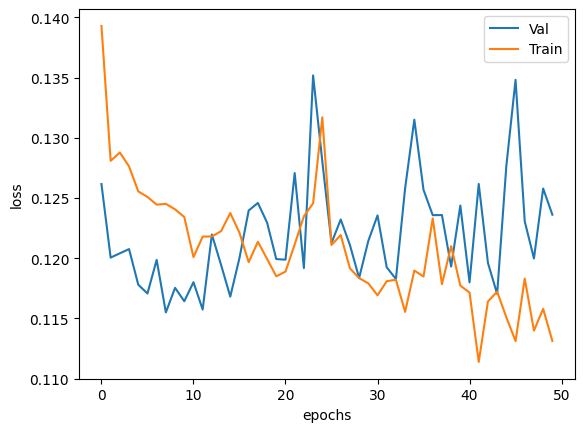

In [ ]:
val_accuracy = history.history['val_loss']
valacc = history.history['loss']
plt.plot(val_accuracy)
plt.plot(valacc)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Val','Train'])
plt.show()

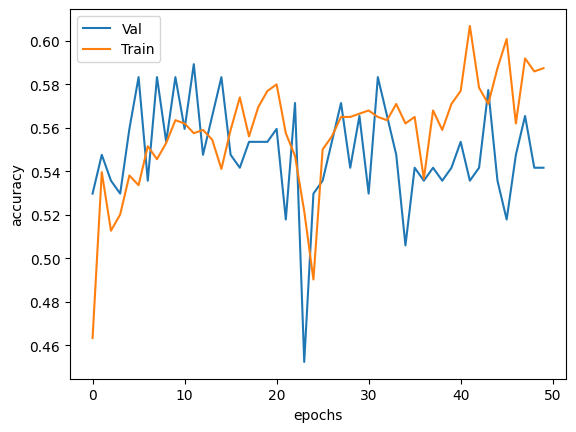

In [ ]:
val_accuracy = history.history['val_accuracy']
valacc = history.history['accuracy']
plt.plot(val_accuracy)
plt.plot(valacc)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Val','Train'])
plt.show()

13/13 [==============================] - 2s 161ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.69      0.77      0.73       162
           1       0.00      0.00      0.00        23
           2       0.41      0.29      0.34        65
           3       0.61      0.71      0.66       131
           4       0.38      0.44      0.41        18

    accuracy                           0.61       399
   macro avg       0.42      0.44      0.43       399
weighted avg       0.57      0.61      0.59       399



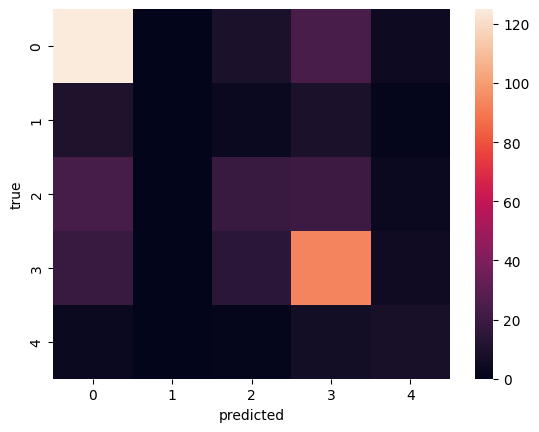

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
y_test_pred_lstm=model.predict(x_test)
y_test_pred_lstm_classes=np.argmax(y_test_pred_lstm,axis=1)
y_test_true_classes=np.argmax(y_test,axis=1)
conf_matrix=confusion_matrix(y_test_true_classes,y_test_pred_lstm_classes)
print(classification_report(y_test_true_classes,y_test_pred_lstm_classes))

sns.heatmap(conf_matrix)
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()

8/8 [==============================] - 1s 144ms/step
              precision    recall  f1-score   support

           0       0.71      0.74      0.72        85
           1       0.00      0.00      0.00        12
           2       0.22      0.20      0.21        25
           3       0.61      0.71      0.65        93
           4       0.40      0.25      0.31        16

    accuracy                           0.60       231
   macro avg       0.39      0.38      0.38       231
weighted avg       0.56      0.60      0.57       231



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(50.722222222222214, 0.5, 'true')

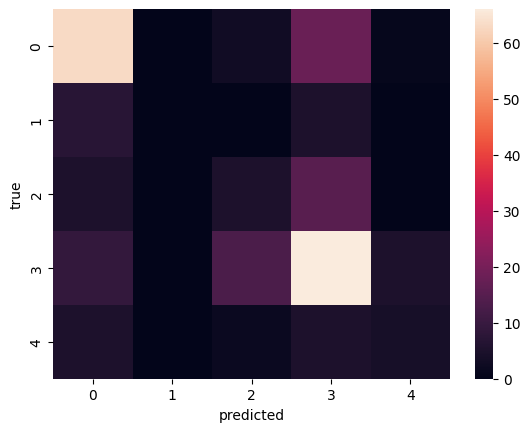

In [ ]:
y_test_pred_lstm=model.predict(x_test_male)
y_test_pred_lstm_classes=np.argmax(y_test_pred_lstm,axis=1)
y_test_true_classes=np.argmax(y_test_male,axis=1)
conf_matrix=confusion_matrix(y_test_true_classes,y_test_pred_lstm_classes)
print(classification_report(y_test_true_classes,y_test_pred_lstm_classes))

sns.heatmap(conf_matrix)
plt.xlabel('predicted')
plt.ylabel('true')

6/6 [==============================] - 1s 170ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.67      0.86      0.75        64
           1       0.00      0.00      0.00        13
           2       0.33      0.16      0.21        38
           3       0.45      0.75      0.56        36
           4       0.38      0.18      0.24        17

    accuracy                           0.54       168
   macro avg       0.37      0.39      0.35       168
weighted avg       0.47      0.54      0.48       168



Text(50.722222222222214, 0.5, 'true')

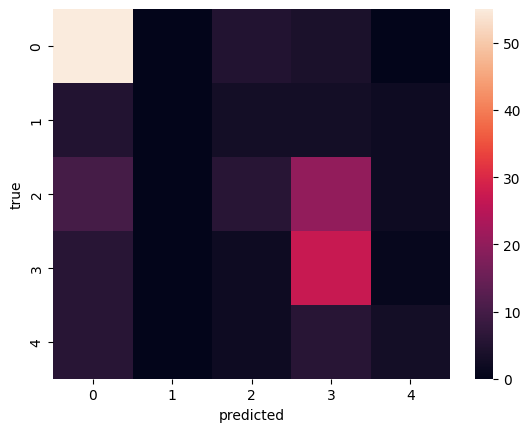

In [ ]:
y_test_pred_lstm=model.predict(x_test_female)
y_test_pred_lstm_classes=np.argmax(y_test_pred_lstm,axis=1)
y_test_true_classes=np.argmax(y_test_female,axis=1)
conf_matrix=confusion_matrix(y_test_true_classes,y_test_pred_lstm_classes)
print(classification_report(y_test_true_classes,y_test_pred_lstm_classes))

sns.heatmap(conf_matrix)
plt.xlabel('predicted')
plt.ylabel('true')